# Configure Tensorflow for GPU
## (Currently using Mobile RTX 2060)

In [1]:
# Importing tensorflow (v2.5) and checking availabilty of GPU

import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
# Checking current status of GPU

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Allocating a fraction (here 50%) of GPU memory for tensorflow

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Model Building for CNN (Last layer as SVM)

In [4]:
# Importing the libraries

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [5]:
# Checking current version of tensorflow

tf.__version__

'2.5.0'

## Part 1 - Data Preprocessing

In [6]:
# Preprocessing the Training set
# Applying data agumentation technique (with rescaling train data set images)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


In [7]:
training_set = train_datagen.flow_from_directory('Downloads/crop_data_set/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

# Note: class_mode is 'binary' for 2 categories and is 'categorical' for more than 2 categories 

# Preprocessing the Test set
# Rescaling test data set images

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('Downloads/crop_data_set/test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 22346 images belonging to 15 classes.
Found 5685 images belonging to 15 classes.


## Part 2 - Building CNN

In [8]:
# Importing 2D Convolution layer and Densely connected NN layer 

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense

In [9]:
# Importing regularizer that applies a L2 regularization penalty.
# The L2 regularization penalty is computed as: loss = l2 * reduce_sum(square(x))

from tensorflow.keras.regularizers import l2

In [10]:
# Initialising the CNN

cnn = tf.keras.models.Sequential()

# Step 1 - Convolution

cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

# Step 2 - Pooling

cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer

cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening

cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection

cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer For Multiple Classification (15 = number of categories)
# Code for normal CNN based model: cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
# Updating Last layer of CNN model (adding regularizers) to integrate with SVM classification technique

cnn.add(Dense(15, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax'))

# Note: For Binary Classification , activation function ='linear' due to linear SVM for binary

In [11]:
# Viewing the structure of our custom build model

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1

## Part 3 - Training custom CNN model (with SVM)

In [12]:
# Compiling the CNN (for multiple classifciation)
# Note: for binary data set, set (for SVM)loss= hinge

cnn.compile(optimizer = 'adam', loss = 'squared_hinge', metrics = ['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set

r=cnn.fit(x = training_set, validation_data = test_set, epochs = 15)

# Note: It will take time to execute (With mobile RTX 2060 and 15 epochs it took ~15 mins. )

Epoch 1/15
699/699 [==============================] - 55s 72ms/step - loss: 1.1069 - accuracy: 0.3803 - val_loss: 1.0504 - val_accuracy: 0.5573
Epoch 2/15
699/699 [==============================] - 38s 54ms/step - loss: 1.0380 - accuracy: 0.6113 - val_loss: 1.0214 - val_accuracy: 0.6825
Epoch 3/15
699/699 [==============================] - 38s 54ms/step - loss: 1.0195 - accuracy: 0.6881 - val_loss: 1.0284 - val_accuracy: 0.6521
Epoch 4/15
699/699 [==============================] - 38s 54ms/step - loss: 1.0096 - accuracy: 0.7287 - val_loss: 1.0274 - val_accuracy: 0.6510
Epoch 5/15
699/699 [==============================] - 38s 54ms/step - loss: 1.0048 - accuracy: 0.7461 - val_loss: 1.0248 - val_accuracy: 0.6566
Epoch 6/15
699/699 [==============================] - 38s 54ms/step - loss: 0.9998 - accuracy: 0.7677 - val_loss: 0.9942 - val_accuracy: 0.7863
Epoch 7/15
699/699 [==============================] - 38s 54ms/step - loss: 0.9947 - accuracy: 0.7864 - val_loss: 0.9912 - val_accuracy:

# Plotting loss and accuracy

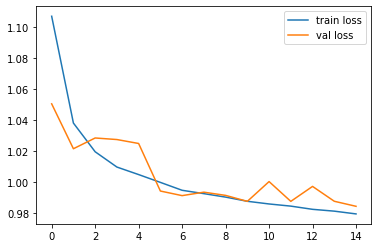

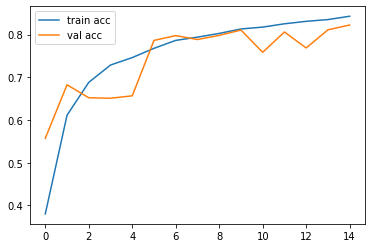

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot the loss

import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Plot the accuracy

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# Saving custom build model  

In [14]:
# Saving it as a h5 file


from tensorflow.keras.models import load_model

cnn.save('model_SVMCNN.h5')

In [15]:
# Importing saved model

from tensorflow.keras.models import load_model
model = load_model('model_SVMCNN.h5')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1